### img2fmri: a python package for predicting group-level fMRI responses to visual stimuli using deep neural networks

Here we present `img2fmri`, a python package and prediction model that allows for prediction of group-averaged cortical responses to visual stimuli. We are publicly releasing this package to aid research investigations into brain respons to visual stimuli, specifically how dynamics in human fMRI responses might be influenced by dynamics in stimuli itself. We encourage viewers to read the science background and summary prior to reading through this notebook, titled `science_overview.pdf`. 

Our model is built by combining a pretrained ResNet-18 DNN with a linear regression model to predict fMRI responses to individual images. The mapping from DNN to the brain is fit using data from the open source BOLD5000 project ([Chang et al. 2019](https://doi.org/10.1038/s41597-019-0052-3)), which includes fMRI responses for three subjects viewing 4916 unique images drawn from ImageNet ([Deng et al. 2009](https://doi.org/10.1109/CVPR.2009.5206848)), COCO ([Lin et al. 2014](https://doi.org/10.48550/arXiv.1405.0312)), and SUN ([Xiao et al. 2010](https://doi.org/10.1109/CVPR.2010.5539970)). For each image, we predict activity patterns for three visual regions of interest (ROIs) in each subject's brain: the lateral occipital complex (LOC), an object-selective region ([Malach et al. 1995](https://doi.org/10.1073/pnas.92.18.8135)), as well as the retrosplenial cortex (RSC) and the parahippocampal place area (PPA), both scene-selective regions ([Epstein 2008](https://doi.org/10.1016/j.tics.2008.07.004)).

For more information on the training of our model using the open source BOLD5000 dataset and pretrained ResNet-18 DNN, we have included a notebook within our `model_training` folder that outlines this process and allows for extensions to other feature-detecting models.

<center>
<img src="https://raw.githubusercontent.com/dpmlab/img2fmri/main/model_overview.png" width="700" class="center"/>
</center>

In this notebook, we show how to predict fMRI responses using our package, we validate our model by predicting brain responses to unseen images from the twinset dataset ([Mohsenzadeh et al. 2019](https://doi.org/10.3390/vision3010008)), and we extend our model to predict a response to a continuous, naturalistic stimulus -- Pixar Animation Studio's short film _Partly Cloudy_ -- which we then compare with human fMRI responses ([Richardson et al. 2018](https://doi.org/10.1038/s41467-018-03399-2)).

## Model validation: Twinset
We first evaluate predictive performance for each region of interest (ROI) in our training set, and show how we can use img2fmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. ([2019](https://doi.org/10.3390/vision3010008)). This dataset is comprised of fMRI data for 15 adults viewing 156 images. These images can also be segmented into five categories: Scenes, Objects, Animals, Bodies, Faces:

<center>
    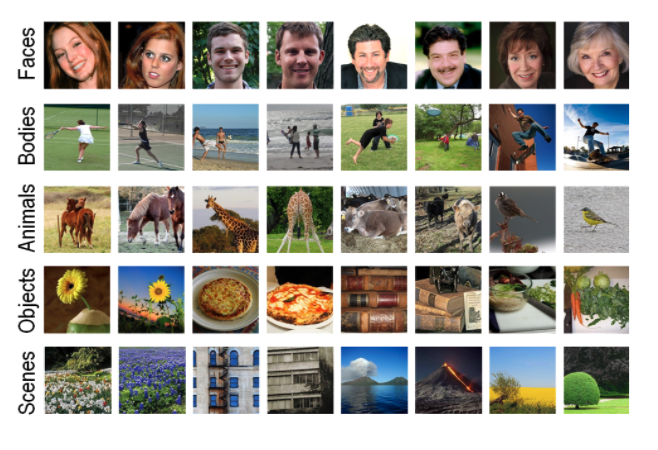
</center>

In [ ]:
import img2fmri
from img2fmri import utils

# Relative import for analysis + plotting scripts
import analysis

import os, sys, wget, zipfile
import nibabel as nib
import numpy as np

# Below commands may be necessary if AFNI's 3D Resample cannot be found in jupyter notebook
# afni_path = !echo ~/abin:$PATH
# %set_env PATH $afni_path.s

In [2]:
# Download fMRI and stimulus data for all analyses filesize: ~3GB
# Includes stimulus set for twinset data, preprocessed human responses to images (only ROIs necessary for analysis)
# Includes preprocessed human responses to Partly Cloudy movie (only ROIs necessary for analysis)
# Includes cached correlations for faster runtime of notebook (run force_resample=True to override)

url = 'https://figshare.com/ndownloader/files/41780682'
filename = wget.download(url)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()
os.remove('data.zip') # remove zip to free space

100% [....................................................................] 3485105299 / 3485105299

### ROI Analysis

We are able to predict into five ROIs (EarlyVis, OPA, LOC, PPA, RSC), and we first validate our model by predicting responses for each image, for each ROI, so that we can test which ROIs have the strongest statistical significance.

In [3]:
ALL_ROIS = ["EarlyVis", "OPA", "LOC", "RSC", "PPA"]
roi_list = ALL_ROIS

# Define our input directory of images, and output directory for our predicted fMRI responses
input_dir = 'data/twinset/156ImageStimuliSet/'

The `img2fmri.predict` function from img2fmri is the main function of this package and takes in an input directory (or movie, as we show later), output directory, and optionally a list of ROIs to then produce a group-averaged fMRI brain for each image input. The function performs the following steps for every image in the input directory:
<ol> 
    <li> Pushes the image through our pretrained DNN and extracts its activations/features </li>
    <li> Predicts fMRI activity in each BOLD5000 subject's brain from those activations/features </li>
    <li> Transforms that subject's predicted brain into the MNI shared brain space </li>
    <li> Smooths each brain as a preprocessing step, with a default sigma=1 (or full width at half maximum (FWHM) of ~2.355mm)</li>
    <li> Averages the three predicted brains to form the group-averaged prediction</li>
</ol> 

The model then saves the brain volume for each image in the output directory using the same filename as each image file, with neuroimaging file extension `.nii.gz`.

Note: This predict function is also available as a command-line interface -- see github README for instructions on usage.

In [4]:
for roi in ALL_ROIS:
    print(f'Predicting twinset images for {roi}:', file=sys.stderr)
    roi_output = f'data/twinset_{roi}/'
    img2fmri.predict(input_data=input_dir, output_dir=roi_output, roi_list=[roi])
    if roi != ALL_ROIS[-1]: print('\n', file=sys.stderr)

Predicting twinset images for EarlyVis:
Averaging MNI brains: 100%|██████████| 156/156 [00:05<00:00]


Predicting twinset images for OPA:
Averaging MNI brains: 100%|██████████| 156/156 [00:05<00:00]


Predicting twinset images for LOC:
Averaging MNI brains: 100%|██████████| 156/156 [00:05<00:00]


Predicting twinset images for RSC:
Averaging MNI brains: 100%|██████████| 156/156 [00:05<00:00]


Predicting twinset images for PPA:
Averaging MNI brains: 100%|██████████| 156/156 [00:05<00:00]


To evaluate our model's performance on a novel dataset, we compare our predicted fMRI responses to fMRI responses from human subjects, and evaulate the significance of our predictions against a null or chance distribution modeled using permutations. We construct our null distributions by taking the correlation matrix of our predicted and our actual, or 'real', human brains, and shuffling the rows of the correlation matrix many times, evaluating the difference between the mean of the diagonal and the mean of the off-diagonal at each resample. This is a proxy for evaluating how well our predicted brain of a specific image correlates with the actual brain of that specific image, taking into account its correlation with all other images. As a result, this models a null distribution by seeing how many times a randomly permuted correlation matrix might produce a better correlation between the predicted and real brains.


In this manner, if our predictions are strong and well above chance, we expect that the difference between the diagonal and off-diagonal of our correlation matrix will be significantly higher when the matrix is properly aligned, with the predicted brains aligned with actual brains from the same image, as opposed to when we correlate our predicted brains with actual brains from a different image in the dataset. 

Our real human fMRI responses have been lightly preprocessed to fairly compare to our prediction, namely by: resampling each brain to MNI space, extracting our ROIs of interest, and smoothing the fMRI responses in those ROIs with a `sigma=1` or full width at half maximum (FWHM) of ~2.355mm.

As a note, we determined from manual inspection that one image overlapped between the Twinset dataset and the BOLD5000 training set, but this image (`020.jpg`) is excluded from the following analyses.

For each analysis in this notebook, we can pass in a boolean argument to `force_resample=True` in order to re-generate the correlations. Depending on the task, this can be a time-consuming process, so we instead draw on cached correlations by default, though perform all shuffling/permutations at runtime.

Generating permutations for 'PPA': 100%|██████████| 10000/10000 [00:02<00:00]


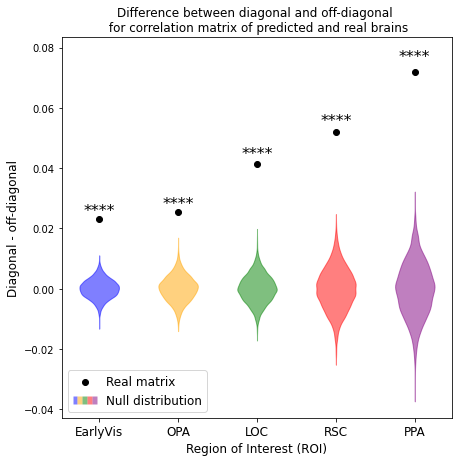

In [5]:
analysis.twinset_ROI_permutations(fmri_dir='data', n_shuffle=10000, print_vals=False, force_resample=False)

Here we performed an analysis to evaluate the statistical significance of our predictions to each ROI, using our 155 predicted brains to the actual 155 brains viewing the same set of images (averaged across participants in MNI space). We see that the difference between the diagonal and off-diagonal in our properly aligned matrix of predicted to real brains is significantly higher than the difference in the shuffled matrices in our null distribution, for all ROIs. As a result, we consider all five ROIs as our default ROIs to predict to. p-values are calculated here as: (the number of shuffled differences greater than the real difference + 1) divided by (the number of resamples + 1).

Throughout this notebook, we use the following convention for significance indicators:
- † = p<0.10
- \* = p<0.05
- \** = p<0.01
- \*** = p<0.001, etc.

### Group level analysis

We now proceed by re-predicting fMRI responses to each Twinset image, however this time predict into all five ROIs, which do include some overlap. Voxel values are averaged in any overlap of ROIs.

In [6]:
output_dir = 'twinset_output/'
img2fmri.predict(input_data=input_dir, output_dir=output_dir, roi_list=roi_list)

Averaging MNI brains: 100%|██████████| 156/156 [00:06<00:00]


To perform this analysis, we generate correlations between all pairs of predicted and actual brains (156 x 156), which are then shuffled (after removing the one repeated image from our training set) to construct our null distribution.

Performing permutation analysis: 100%|██████████| 10000/10000 [00:02<00:00]


Real difference:      0.08590207
Mean null difference: 0.00003679
p value:              0.00009999


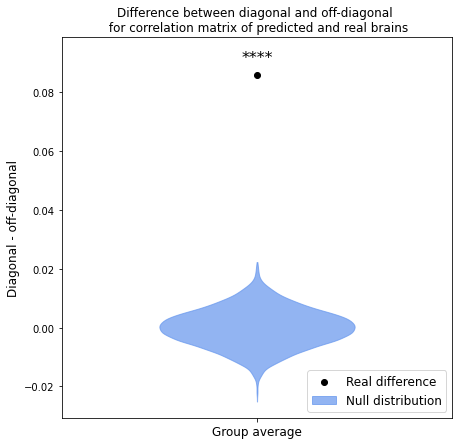

In [7]:
analysis.twinset_group_permutations(fmri_dir=output_dir, roi_list=roi_list, n_shuffle=10000, print_vals=True, force_resample=False)

### Category level analysis

Next we perform a similar analysis, now considering each image as a part of one of the five twinset categories: animals, objects, scenes, people, or faces. Thus, we can better understand how well our model predicts the fMRI responses to specific categories of visual stimulus. In this analysis, we still average each real or actual brain across all 15 subjects and correlate this averaged brain with all predicted brains to images within the same category.

Again we permute null distributions through the same shuffling mechanism as previously explained:

Generating permutations for 'faces': 100%|██████████| 10000/10000 [00:01<00:00]


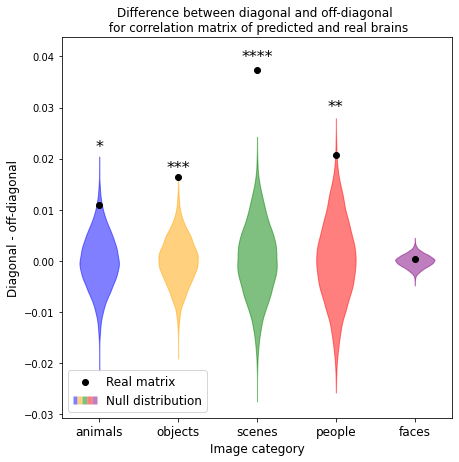

In [8]:
analysis.twinset_category_permutations(fmri_dir=output_dir, roi_list=roi_list, n_shuffle=10000, print_vals=False, force_resample=False)

Here we see that our predicted brains perform well above chance in four of the five categories: animals (p<0.05) objects (p<0.001), scenes (p<0.0001), and people (p<0.01). We argue that our model performs strongest in these categories because they have the largest overlap with the BOLD5000 dataset used to train our model. The images from the BOLD5000 dataset were chosen to "cover the following image domains: real-world indoor and outdoor scenes; objects interacting in complex, real-world scenes; and objects centered in real-world scenes," as the authors write in Chang et al. ([2019](https://doi.org/10.1038/s41597-019-0052-3)). As a result, we find the high significance in the scene and objects categories to be validation of our model and its training set.

Additionally, we note that our model seems to not predict well into the face category -- we argue that this is due to a lack of differentiation between images in this categories that our model can pick up, as our DNN was not trained to differentiate faces.

### Participant level analysis

Our final validation analysis with the Twinset dataset investigates our model's prediction capabilities for each participant. Here we consider all 155 images per subject, and compare our predicted fMRI response to each subject's actual fMRI response.

Generating permutations for each participant: 100%|██████████| 15/15 [00:03<00:00]


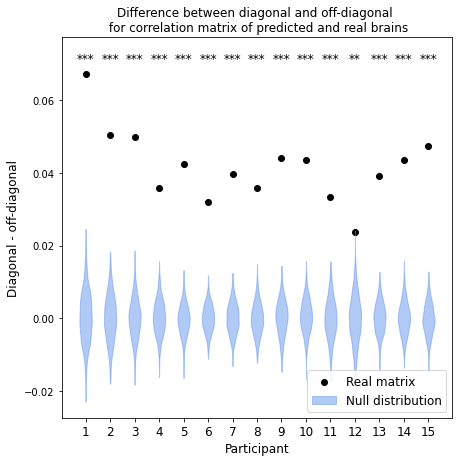

In [9]:
analysis.twinset_participant_permutations(fmri_dir=output_dir, roi_list=roi_list, n_shuffle=1000, print_vals=False, force_resample=False)

Here, we again see that the diagonal - off-diagonal difference in each un-shuffled/real matrix is significantly higher than its corresponding null distribution, for all subjects. This suggests our model has predictive power within each subject, predicting well above chance which image a participant is viewing, from a set of 155.

## Extending our model to movies

In this final section, we extend our image prediction model to process movies, specifically to Pixar Animation Studio's _Partly Cloudy_, and compare our model to a baseline luminance model. In these analyses, in contrast to the twinset validation analyses, we do not explicitly compare our predicted fMRI responses to human fMRI responses on the voxel level, but instead compare correlation matrices to gauge how well our predicted reponses can model the event structure present in the human brain responses to the same stimulus. We thus compare how well our predicted brain responses represent the timepoint-timepoint similarity throughout the movie, as observed in our human subjects, to a baseline luminance model whose correlation matrix represents how similar the luminance is across frames of the movie.

#### Prediction

Due to copyright reasons we are unable to publicly release the _Partly Cloudy_ movie used for predicting the fMRI responses. We have, however, included code here showing the use of our `predict()` function with `predict_movie=True` allowing for frame-by-frame fMRI prediction function to movies. This is performed by first splitting a movie into frames at a rate of 2Hz, predicting an fMRI response for each frame, and then recombining those frames into a 4-dimensional brain volume with dimensions: (x, y, z, time).

In [9]:
# # Predicting the fMRI response to partly_cloudy requires a download of the movie. 
# # We have included this code for reproducibility, but instead load a predicted version for copyright reasons.

# # Define filenames/directories
# movie_filename = 'PartlyCloudy.m4v'
# movie_data = 'data/partly_cloudy'
# roi_list = ALL_ROIS

# # Predict response to movie
# img2fmri.predict(movie_filename, movie_data, predict_movie=True, roi_list=roi_list, center_crop=False)

Loading movie frames: 100%|██████████| 691/691 [00:09<00:00]


Saved data/partly_cloudy/PartlyCloudy.nii.gz


In [10]:
# Loading the fMRI prediction (given that above code will not run without the movie downloaded)
movie_data = "data/partly_cloudy" # directory for saving/loading correlations
pred_fmri = nib.load(f'{movie_data}/PartlyCloudy.nii.gz').get_fdata()

After predicting (or loading) our fMRI response to the movie, we preprocess the predicted brain response by:
   1. Convolving the response with a hemodynamic response function (HRF) and downsampling the frames to match the responses we have per repetition time (TR) for our human fMRI data
   2. Removing the average activity to focus on dynamics in responses over time</li>
   3. Removing high-pass filtered activity above 120s, by regressing out a discrete cosine transformation (DCT) basis set from the brain response.
   4. Trimming some of the opening and ending credits to match the human fMRI data we have from Richardson et al. ([2018](https://doi.org/10.1038/s41467-018-03399-2)).


These steps are now run, and the correlation matrix at each step visualized:

In [11]:
overlap = utils.get_subj_overlap(roi_list) # boolean mask of ROIs in MNI brain

# Preprocessing steps:
pred_voxels = pred_fmri[overlap] # get our voxels of interest
conv_and_downsampled = utils.conv_hrf_and_downsample(pred_voxels, TR=2, num_TR=168) # convolve with HRF and downsample
removed_avg = utils.remove_average_activity(conv_and_downsampled)
removed_dct = utils.remove_DCT(removed_avg)
trimmed_pred = removed_dct[:, 2:-8] # trim opening and closing credits to match real fMRI response
pred = np.corrcoef(trimmed_pred.T) # get correlation matrix of preprocessed response

Removing average activity: 100%|██████████| 168/168 [00:00<00:00]


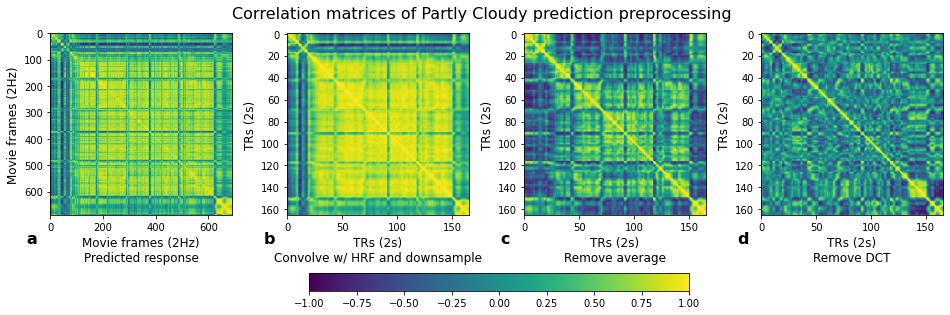

In [12]:
analysis.plot_preprocessing_matrices(pred_voxels, conv_and_downsampled, removed_avg, removed_dct)

Here we visualize the preprocessing steps we apply to our fMRI prediction to prepare the response for comparison to our real fMRI responses. We note that the preprocessing steps are visualized left to right. (a) The correlation matrix of all frames of the movie immediately after prediction. (b) The correlation matrix after the prediction was convolved with the HRF and downsampled to our repetition time (TR) timescale of 2 seconds. (c) The correlation matrix after the convolved and downsampled response had the mean activity over time removed from each response. (d) The correlation matrix after removing high-pass filtered activity above 120s, by regressing out a discrete cosine transformation (DCT) basis set.

#### Human fMRI response

For the real fMRI response and the image luminance, we provide information in the following code snippets about their preprocessing steps to ensure the brain responses are compared as closely as possible to the processing of our prediction, and that all three models are on the same timescale.

In [13]:
# Loading the real, group-averaged human fMRI response to Partly Cloudy

# All fMRI data downloaded from https://openneuro.org/datasets/ds000228/versions/1.1.0 in derivatives > preprocessed_data folder.

# Preprocessing steps:
# For each participant, the fMRI response was resampled to MNI space, removed of nuisance regressors,
# isolated to our regions of interest, smoothed in the same manner as our prediction process, z-scored across time,
# removed of average activity, and removed of stable activity found from the discrete cosine transform.
# Averaging of participants was conducted by adding subject's voxels together and z-scoring once again,
# and responses were trimmed of their first 10 TRs to account for the opening credits.

real = nib.load(f'{movie_data}/real_group_avg_preprocessed.nii.gz').get_fdata()
real = np.corrcoef(real[overlap].T)

#### Baseline image luminance model

In [14]:
# Loading luminance model

# We generate the luminance by: pushing each frame through the same resizing transform as our prediction pipeline,
# then convolving with our HRF and downsampling to our TR space, to account for the BOLD delay inherent
# in our real brain response, then calculating the luminance of each pixel based on its RGB values with
# the formula: R * 0.2126 + G * 0.7152 + B * 0.0722. See more: https://en.wikipedia.org/wiki/Relative_luminance

# # Below commented-out code will only work if movie downloaded and frames have been extracted
# lum = analysis.get_luminance(input_dir='temp/movie_frames', center_crop=False)
# lum = np.corrcoef(lum)
# np.save(f'{movie_data}/luminance_partly_cloudy.npy', lum)
lum = np.load(f'{movie_data}/luminance_partly_cloudy.npy') # load pre-saved luminance values

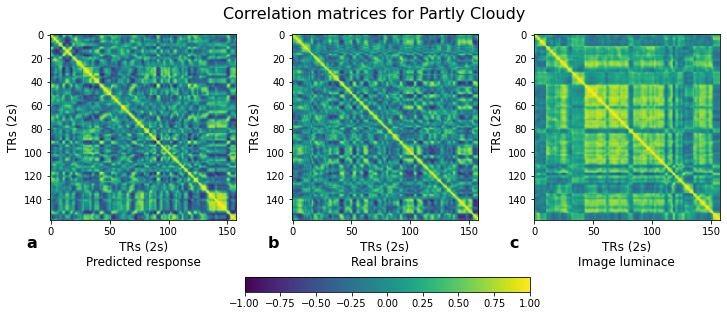

In [15]:
analysis.plot_correlation_matrices(pred, real, lum)

Here we see the correlation matrices, or timepoint-timepoint similarity, for (a) the predicted fMRI response, (b) the real fMRI response, and (c) the luminance baseline, where local coherence can be seen in regions with more yellow, and local dissimilarities, or lower pearson correlation values, can be seen in darker blue bands. We note, again, that the predicted and real brains have been preprocessed in nearly identical manners, and the image luminance model has been convolved and downsampled in the same way as the prediction, to align their timescales to the real fMRI response.

### Comparing prediction vs. baseline luminance model

At each timepoint in the movie (or, for each row in the correlation matrix) we compare the correlation structure of our predicted brain responses and luminance model to the correlation structure of the real fMRI responses. In this manner, we can compare the two models by evaluating how closely they resemble the structure of the real fMRI response. Additionally, we perform this analysis 100 times, each time with a separate bootstrap of the 33 real brains, which are averaged together and subsequently used for this analysis.

In [16]:
corr = analysis.generate_bootstrapped_correlations(pred, real, lum, TR_band=None, force_resample=False, roi_list=roi_list)

Generating and loading bootstraps: 100%|██████████| 100/100 [02:43<00:00]


#### On the full movie timecourse

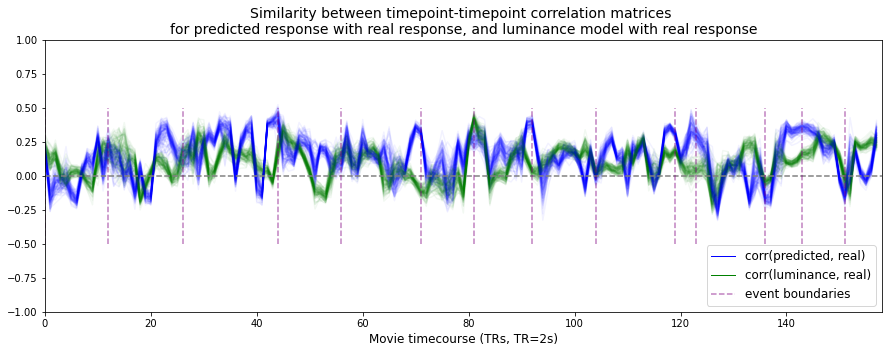

In [17]:
analysis.pc_pred_lum_timecourse(corr)

Here we see the correlation of rows of the predicted brain correlation matrix with rows of the real group-averaged correlation matrix, as well as the correlation of rows of the luminance correlation matrix with rows of the real group-averaged correlation matrix. As previously mentioned, this analysis is performed 100 times with a different group-averaged permutation of the 33 adult participants from Richardson et al. ([2018](https://doi.org/10.1038/s41467-018-03399-2)). We show these results for all timepoints of the movie (158 TRs) and plot these correlations against human annotated event boundaries, which were collected from asking members of our lab to "watch this short silent film... and write down the timepoints (in minutes/seconds) of each place you think a meaningful segment of the movie has ended."

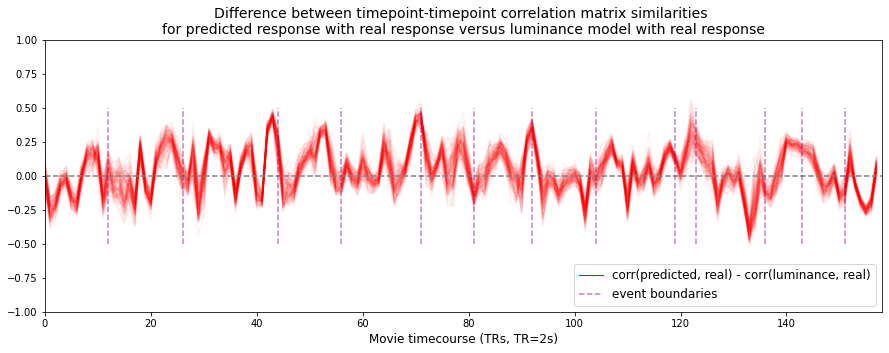

In [18]:
analysis.pc_difference_timecourse(corr)

Here we plot the difference between the predicted to real correlation and the luminance to real correlation, for each of the 100 permutations of the real brains, demonstrating where our predicted fMRI response is better or worse than the luminance model. We notice that in several cases, a positive spike in the difference is seen around an event boundary -- something we now investigate further.

#### Boundary triggered averages with bootstraps

To analyze how well our prediction model and the baseline model compare to the real fMRI responses around our human-annotated event boundaries, we perform a boundary triggered average analysis. To conduct this analysis, we take 10 random resamples of our 13 human-annotated event boundaries for each bootstrapped brain response, and average the correlations at each TR lag from the event boundary, skipping any TRs that are ±2 from another event boundary. Additionally, as we perform this analysis for all 100 bootstraps of our real brain responses, this results in 1000 samples considered for our boundary triggered average.

In [19]:
np.random.seed(0)

In [20]:
bound_averages = analysis.generate_boundary_triggered_averages(corr, num_boundary_bootstraps=10)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:04<00:00]


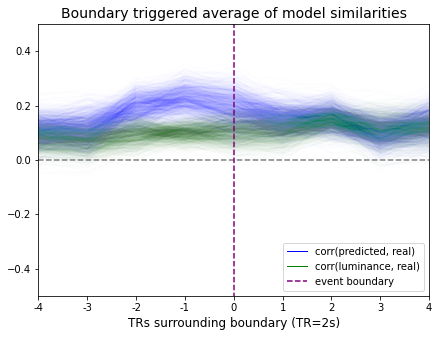

In [21]:
analysis.pc_bootstrapped_pred_lum_4TRs(bound_averages)

Here we see that around event boundaries, our predicted fMRI response seems to perform better at modeling the structure of the real fMRI response. To further understand whether this result is significant, we take the difference between our predicted model and our baseline luminance model, and then evaluate the significance.

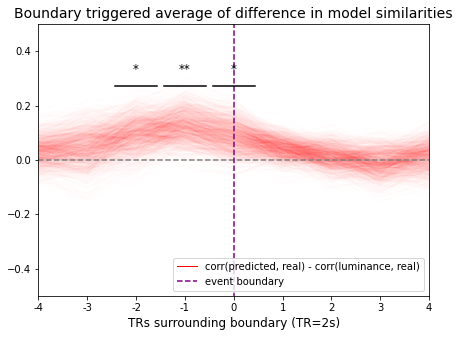

In [22]:
analysis.pc_bootstrapped_difference_4TRs(bound_averages)

Here we see that in the two TRs prior to an event boundary, and at the event boundary itself, our predicted brain response more closely models the event structure we see in the real fMRI response than the model based purely on the luminance of image frames (\* p<0.05, \*\* p<0.01).

Because our frame by frame model succeeds at predicting dynamics in fMRI responses around event boundaries, specifically in our visual areas of interest in the neocortex, we argue that at least a portion of the event boundary changes we see in human fMRI responses are explained by inherent event structure in the semantic content of the visual stimuli itself. 

## Summary

In this notebook we:
- Showed how to use the `img2fmri` python package to predict group-average fMRI responses to visual stimuli using `img2fmri.predict()`
- Validated our predicted fMRI responses against an unseen dataset (Twinset) of 155 unique images, showing we have predictive power in the following areas:
    - Across all ROIs
    - At the group-level
    - Within image categories, specifically within 'objects,' 'scenes,' and 'people'
    - Within subjects
- Extended our model to predict fMRI responses to movies with Pixar Animation Studio's _Partly Cloudy_, concluding that the event structure observed in the visual ROIs of our 33 human fMRI responses to _Partly Cloudy_ can be partially explained by our predicted responses. These analyses suggest that in visual areas of the brain, at least some of the temporal dynamics we see in the brain’s processing of continuous, naturalistic stimuli can be explained by dynamics in the stimulus itself, since they can be predicted from our frame-by-frame model.